In [1]:
# !pip install --user git+https://github.com/gaarangoa/METk.git

In [2]:
%load_ext autoreload
%autoreload 2
# ------------
import numpy as np
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

from metaCH.src.feature_extraction.extract_features import extract_features
from metaCH.src.classification.inference import inference

## Tumor somatic prediction (GENIE)

In [3]:
# Create output directory if it doesn't exist
os.makedirs('/data/genie_v17.0/mutation', exist_ok=True)

# Read the large file
df = pd.read_csv('/data/genie_v17.0/data_mutations_extended.txt', sep='\t')
df = df[df['Chromosome'] != 'MT']

# Split into 10 approximately equal parts
n_splits = 30
dfs = np.array_split(df, n_splits)

# Save each part to a separate file
for i, split_df in enumerate(dfs, 1):
    output_file = f'/data/genie_v17.0/mutation/mutations_part_{i:02d}.txt'
    split_df.to_csv(output_file, sep='\t', index=False)
    print(f"Saved {len(split_df)} rows to {output_file}")

print(f"\nTotal rows: {len(df)}")
print(f"Files created: {n_splits}")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4,12,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_01.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_02.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_03.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_04.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_05.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_06.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_07.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_08.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_09.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_10.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_11.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_12.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_13.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_14.txt
Saved 75434 rows to /data/genie_v1

In [4]:
data_sample = pd.read_csv('/data/genie_v17.0/data_clinical_sample.txt', sep='\t', comment='#')
for i in range(1, n_splits+1):
    example_cfDNA_input = pd.read_csv(f'/data/genie_v17.0/mutation/mutations_part_{i:02d}.txt', sep='\t')
    example_cfDNA_input = example_cfDNA_input.rename(columns={'NCBI_Build': 'Reference_Genome',
                                                              'Tumor_Seq_Allele1': 'Tumor_Allele_1',
                                                              'Tumor_Seq_Allele2': 'Tumor_Allele_2',
                                                              'Tumor_Sample_Barcode': 'SAMPLE_ID'})
    example_cfDNA_input = pd.merge(example_cfDNA_input, data_sample[['SAMPLE_ID', 'CANCER_TYPE']], on='SAMPLE_ID', how='left')
    example_cfDNA_input = example_cfDNA_input.rename(columns={'SAMPLE_ID': 'Sample_ID'})
    example_cfDNA_input['Gene_Name'] = example_cfDNA_input['Hugo_Symbol']
    example_cfDNA_input['VAF'] = example_cfDNA_input['t_alt_count'] / (example_cfDNA_input['t_alt_count'] + example_cfDNA_input['t_ref_count'])
    example_cfDNA_input = example_cfDNA_input[~np.isinf(example_cfDNA_input['VAF'])]
    example_cfDNA_input = example_cfDNA_input[['Chromosome', 'Start_Position', 'End_Position','Reference_Allele','Tumor_Allele_1','Tumor_Allele_2', 'Variant_Type','Hugo_Symbol','Gene_Name','Reference_Genome','VAF','CANCER_TYPE','Sample_ID']].dropna()
    if len(example_cfDNA_input) > 0:
        features = extract_features(example_cfDNA_input, 'paper')
        results = inference(features, 'paper')
        threshold=0.5
        results['prediction']=np.where(results['ch_score_meta'] > threshold, 'CHIP', 'TUMOR-SOMATIC')
        results['ground_truth'] = 'TUMOR-SOMATIC'
        results.to_csv(f"/METk/MetaCH/results/genie_results/genie_tumor_somatic_results_{i:02d}.csv", index=False)
    else:
        print(f'/data/genie_v17.0/mutation/mutations_part_{i:02d}.txt has no samples left after filtering!')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmpu54c6hxj
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmpu54c6hxj/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,Variant_Type,Hugo_Symbol
Consequence types: ['INS', 'DEL', 'SNP']
Parsing input file /tmp/tmpu54c6hxj/deepgesture.tsv


59716it [00:00, 326371.64it/s]

Total entries in the input file: 59715


Processing 59714 entries in core
Filtered entries 0 in core 
Processing /tmp/tmpu54c6hxj/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmpu54c6hxj/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (59715, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (59715, 8)
[features, feature_names, dataset] stored in: /tmp/tmpu54c6hxj/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmpzaqtj6yo
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmpzaqtj6yo/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74616it [00:00, 321541.56it/s]

Total entries in the input file: 74615


Processing 74614 entries in core
Filtered entries 0 in core 
Processing /tmp/tmpzaqtj6yo/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmpzaqtj6yo/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74615, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74615, 8)
[features, feature_names, dataset] stored in: /tmp/tmpzaqtj6yo/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmp0768e8ke
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmp0768e8ke/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74547it [00:00, 319020.33it/s]

Total entries in the input file: 74546


Processing 74545 entries in core
Filtered entries 0 in core 
Processing /tmp/tmp0768e8ke/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmp0768e8ke/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74546, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74546, 8)
[features, feature_names, dataset] stored in: /tmp/tmp0768e8ke/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmprgqsw2ew
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmprgqsw2ew/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74309it [00:00, 317473.18it/s]

Total entries in the input file: 74308


Processing 74307 entries in core
Filtered entries 0 in core 
Processing /tmp/tmprgqsw2ew/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmprgqsw2ew/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74308, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74308, 8)
[features, feature_names, dataset] stored in: /tmp/tmprgqsw2ew/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmprhy_esd0
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmprhy_esd0/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

73753it [00:00, 278623.68it/s]

Total entries in the input file: 73752


Processing 73751 entries in core
Filtered entries 0 in core 
Processing /tmp/tmprhy_esd0/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmprhy_esd0/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (73752, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (73752, 8)
[features, feature_names, dataset] stored in: /tmp/tmprhy_esd0/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmpame1hm5i
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmpame1hm5i/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74032it [00:00, 274643.94it/s]

Total entries in the input file: 74031


Processing 74030 entries in core
Filtered entries 0 in core 
Processing /tmp/tmpame1hm5i/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmpame1hm5i/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74031, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74031, 8)
[features, feature_names, dataset] stored in: /tmp/tmpame1hm5i/mutation_features.pk


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmptj70vniv
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmptj70vniv/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,Variant_Type,Hugo_Symbol
Consequence types: ['INS', 'DEL', 'SNP']
Parsing input file /tmp/tmptj70vniv/deepgesture.tsv


71437it [00:00, 273938.54it/s]

Total entries in the input file: 71436


Processing 71435 entries in core
Filtered entries 0 in core 
Processing /tmp/tmptj70vniv/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmptj70vniv/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (71436, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (71436, 8)
[features, feature_names, dataset] stored in: /tmp/tmptj70vniv/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmptijj4q9x
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmptijj4q9x/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74262it [00:00, 314709.79it/s]

Total entries in the input file: 74261


Processing 74260 entries in core
Filtered entries 0 in core 
Processing /tmp/tmptijj4q9x/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmptijj4q9x/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74261, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74261, 8)
[features, feature_names, dataset] stored in: /tmp/tmptijj4q9x/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmpxj9ic9wz
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmpxj9ic9wz/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74256it [00:00, 312734.14it/s]

Total entries in the input file: 74255


Processing 74254 entries in core
Filtered entries 0 in core 
Processing /tmp/tmpxj9ic9wz/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmpxj9ic9wz/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74255, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74255, 8)
[features, feature_names, dataset] stored in: /tmp/tmpxj9ic9wz/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmp10ttlbyz
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmp10ttlbyz/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74295it [00:00, 322522.23it/s]

Total entries in the input file: 74294


Processing 74293 entries in core
Filtered entries 0 in core 
Processing /tmp/tmp10ttlbyz/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmp10ttlbyz/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74294, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74294, 8)
[features, feature_names, dataset] stored in: /tmp/tmp10ttlbyz/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmp8ho7ebxq
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmp8ho7ebxq/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74256it [00:00, 264233.68it/s]

Total entries in the input file: 74255


Processing 74254 entries in core
Filtered entries 0 in core 
Processing /tmp/tmp8ho7ebxq/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmp8ho7ebxq/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74255, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74255, 8)
[features, feature_names, dataset] stored in: /tmp/tmp8ho7ebxq/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmprojfh1e5
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmprojfh1e5/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74252it [00:00, 317517.83it/s]

Total entries in the input file: 74251


Processing 74250 entries in core
Filtered entries 0 in core 
Processing /tmp/tmprojfh1e5/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmprojfh1e5/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74251, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74251, 8)
[features, feature_names, dataset] stored in: /tmp/tmprojfh1e5/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmp4x77cs1k
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmp4x77cs1k/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74258it [00:00, 319927.84it/s]

Total entries in the input file: 74257


Processing 74256 entries in core
Filtered entries 0 in core 
Processing /tmp/tmp4x77cs1k/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmp4x77cs1k/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74257, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74257, 8)
[features, feature_names, dataset] stored in: /tmp/tmp4x77cs1k/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmpt7_ofsb7
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmpt7_ofsb7/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74243it [00:00, 318346.58it/s]

Total entries in the input file: 74242


Processing 74241 entries in core
Filtered entries 0 in core 
Processing /tmp/tmpt7_ofsb7/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmpt7_ofsb7/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74242, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74242, 8)
[features, feature_names, dataset] stored in: /tmp/tmpt7_ofsb7/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmp2187auv8
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmp2187auv8/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74155it [00:00, 316304.90it/s]

Total entries in the input file: 74154


Processing 74153 entries in core
Filtered entries 0 in core 
Processing /tmp/tmp2187auv8/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmp2187auv8/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74154, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74154, 8)
[features, feature_names, dataset] stored in: /tmp/tmp2187auv8/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmpymd4wx1x
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmpymd4wx1x/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74217it [00:00, 316235.85it/s]

Total entries in the input file: 74216


Processing 74215 entries in core
Filtered entries 0 in core 
Processing /tmp/tmpymd4wx1x/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmpymd4wx1x/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74216, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74216, 8)
[features, feature_names, dataset] stored in: /tmp/tmpymd4wx1x/mutation_features.pk


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmp8gzfn9oy
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmp8gzfn9oy/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,Variant_Type,Hugo_Symbol
Consequence types: ['INS', 'DEL', 'SNP']
Parsing input file /tmp/tmp8gzfn9oy/deepgesture.tsv


74529it [00:00, 315561.35it/s]

Total entries in the input file: 74528


Processing 74527 entries in core
Filtered entries 0 in core 
Processing /tmp/tmp8gzfn9oy/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmp8gzfn9oy/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74528, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74528, 8)
[features, feature_names, dataset] stored in: /tmp/tmp8gzfn9oy/mutation_features.pk


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmpjczsh_4s
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmpjczsh_4s/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,Variant_Type,Hugo_Symbol
Consequence types: ['INS', 'DEL', 'SNP']
Parsing input file /tmp/tmpjczsh_4s/deepgesture.tsv


75386it [00:00, 320757.79it/s]

Total entries in the input file: 75385


Processing 75384 entries in core
Filtered entries 0 in core 
Processing /tmp/tmpjczsh_4s/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmpjczsh_4s/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (75385, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (75385, 8)
[features, feature_names, dataset] stored in: /tmp/tmpjczsh_4s/mutation_features.pk


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmpao8dwn3s
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmpao8dwn3s/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,Variant_Type,Hugo_Symbol
Consequence types: ['INS', 'DEL', 'SNP']
Parsing input file /tmp/tmpao8dwn3s/deepgesture.tsv


67675it [00:00, 315821.39it/s]

Total entries in the input file: 67674


Processing 67673 entries in core
Filtered entries 0 in core 
Processing /tmp/tmpao8dwn3s/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmpao8dwn3s/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (67674, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (67674, 8)
[features, feature_names, dataset] stored in: /tmp/tmpao8dwn3s/mutation_features.pk


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmpebyf3mgu
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmpebyf3mgu/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,Variant_Type,Hugo_Symbol
Consequence types: ['INS', 'DEL', 'SNP']
Parsing input file /tmp/tmpebyf3mgu/deepgesture.tsv


53454it [00:00, 305852.79it/s]

Total entries in the input file: 53453


Processing 53452 entries in core
Filtered entries 0 in core 
Processing /tmp/tmpebyf3mgu/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmpebyf3mgu/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (53453, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (53453, 8)
[features, feature_names, dataset] stored in: /tmp/tmpebyf3mgu/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmpimww22vu
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmpimww22vu/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74214it [00:00, 281388.66it/s]

Total entries in the input file: 74213


Processing 74212 entries in core
Filtered entries 0 in core 
Processing /tmp/tmpimww22vu/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmpimww22vu/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74213, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74213, 8)
[features, feature_names, dataset] stored in: /tmp/tmpimww22vu/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmp8dafqwgh
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmp8dafqwgh/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74124it [00:00, 274867.82it/s]

Total entries in the input file: 74123


Processing 74122 entries in core
Filtered entries 0 in core 
Processing /tmp/tmp8dafqwgh/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmp8dafqwgh/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74123, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74123, 8)
[features, feature_names, dataset] stored in: /tmp/tmp8dafqwgh/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmpajp4ktpf
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmpajp4ktpf/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74007it [00:00, 279525.09it/s]

Total entries in the input file: 74006


Processing 74005 entries in core
Filtered entries 0 in core 
Processing /tmp/tmpajp4ktpf/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmpajp4ktpf/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74006, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74006, 8)
[features, feature_names, dataset] stored in: /tmp/tmpajp4ktpf/mutation_features.pk
/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmpdtkgxsm0
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmpdtkgxsm0/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,

74234it [00:00, 279309.23it/s]

Total entries in the input file: 74233


Processing 74232 entries in core
Filtered entries 0 in core 
Processing /tmp/tmpdtkgxsm0/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmpdtkgxsm0/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (74233, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (74233, 8)
[features, feature_names, dataset] stored in: /tmp/tmpdtkgxsm0/mutation_features.pk


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmpasw0etjy
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmpasw0etjy/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,Variant_Type,Hugo_Symbol
Consequence types: ['INS', 'DEL', 'SNP']
Parsing input file /tmp/tmpasw0etjy/deepgesture.tsv


32892it [00:00, 275325.59it/s]

Total entries in the input file: 32891


Processing 32890 entries in core
Filtered entries 0 in core 
Processing /tmp/tmpasw0etjy/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmpasw0etjy/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (32891, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (32891, 8)
[features, feature_names, dataset] stored in: /tmp/tmpasw0etjy/mutation_features.pk


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4,12,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmphnsrnnd7
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmphnsrnnd7/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,Variant_Type,Hugo_Symbol
Consequence types: ['INS', 'DEL', 'SNP']
Parsing input file /tmp/tmphnsrnnd7/deepgesture.tsv


17466it [00:00, 392482.88it/s]

Total entries in the input file: 17465


Processing 17464 entries in core
Filtered entries 0 in core 
Processing /tmp/tmphnsrnnd7/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmphnsrnnd7/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (17465, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (17465, 8)
[features, feature_names, dataset] stored in: /tmp/tmphnsrnnd7/mutation_features.pk


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmpjkib6g_9
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmpjkib6g_9/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,Variant_Type,Hugo_Symbol
Consequence types: ['INS', 'DEL', 'SNP']
Parsing input file /tmp/tmpjkib6g_9/deepgesture.tsv


6112it [00:00, 376960.65it/s]

Total entries in the input file: 6111


Processing 6110 entries in core
Filtered entries 0 in core 
Processing /tmp/tmpjkib6g_9/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmpjkib6g_9/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (6111, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (6111, 8)
[features, feature_names, dataset] stored in: /tmp/tmpjkib6g_9/mutation_features.pk
/data/genie_v17.0/mutation/mutations_part_28.txt has no samples left after filtering!
/data/genie_v17.0/mutation/mutations_part_29.txt has no samples left after filtering!
/data/genie_v17.0/mutation/mutations_part_30.txt has no samples left after filtering!


## CH prediction msk_ch_2023

In [5]:
# example_cfDNA_input=pd.read_csv('example_input.csv')
example_cfDNA_input = pd.read_csv('/data/msk_ch_2023/data_mutations.txt', sep='\t')

data_sample = pd.read_csv('/data/genie_v17.0/data_clinical_sample.txt', sep='\t', comment='#')
example_cfDNA_input = example_cfDNA_input.rename(columns={'NCBI_Build': 'Reference_Genome',
                                                          'Tumor_Seq_Allele1': 'Tumor_Allele_1',
                                                          'Tumor_Seq_Allele2': 'Tumor_Allele_2',
                                                          'Tumor_Sample_Barcode': 'SAMPLE_ID'})
example_cfDNA_input = pd.merge(example_cfDNA_input, data_sample[['SAMPLE_ID', 'CANCER_TYPE']], on='SAMPLE_ID', how='left')
example_cfDNA_input = example_cfDNA_input.rename(columns={'SAMPLE_ID': 'Sample_ID'})
example_cfDNA_input['Gene_Name'] = example_cfDNA_input['Hugo_Symbol']
example_cfDNA_input['VAF'] = example_cfDNA_input['t_alt_count'] / (example_cfDNA_input['t_alt_count'] + example_cfDNA_input['t_ref_count'])
example_cfDNA_input = example_cfDNA_input[~np.isinf(example_cfDNA_input['VAF'])]
# example_cfDNA_input = example_cfDNA_input[['Chromosome', 'Start_Position', 'End_Position','Reference_Allele','Tumor_Allele_1','Tumor_Allele_2', 'Variant_Type','Hugo_Symbol','Gene_Name','Reference_Genome','VAF','CANCER_TYPE','Sample_ID']].dropna()
features = extract_features(example_cfDNA_input, 'paper')
results = inference(features, 'paper')
threshold=0.5
results['prediction']=np.where(results['ch_score_meta'] > threshold, 'CHIP', 'TUMOR-SOMATIC')
results['ground_truth'] = 'CHIP'
results.to_csv("/METk/MetaCH/results/msk_ch_2023.csv")

/METk/METk/dgv2.cbioportal.128.e500.bin
ref_g:  GRCh37
model_path:  /METk/METk
output_path:  /tmp/tmpyd6hznlp
Directory exists: True
Step 1: Extracting DeepGESTURE embeddings ...
Processing: /tmp/tmpyd6hznlp/deepgesture.tsv variants file
Reference genome: GRCh37
Columns used: Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Allele_1,Tumor_Allele_2,Variant_Type,Hugo_Symbol
Consequence types: ['INS', 'DEL', 'SNP']
Parsing input file /tmp/tmpyd6hznlp/deepgesture.tsv


29997it [00:00, 269163.13it/s]

Total entries in the input file: 29996


Processing 29995 entries in core
Filtered entries 0 in core 
Processing /tmp/tmpyd6hznlp/tokens.txt
Text model: /METk/METk/starspace/dgv2.cbioportal.128.e500.bin
Storing embeddings to /tmp/tmpyd6hznlp/embeddings.wv
STDOUT: b'Start to load a trained starspace model.\nSTARSPACE-2018-2\n# Model loaded.\n'
STDERR: None
Step 1: Feature dimension: (29996, 128)
Step 2: Extracting SnpEff features ...
Step 2: Feature dimension: (0,)
Step 3: Extracting DbnSPF features ...
Step 4: Extracting Individual Gene features ...
Step 4: Feature dimension: (29996, 8)
[features, feature_names, dataset] stored in: /tmp/tmpyd6hznlp/mutation_features.pk


## Performance analysis and Visualization

In [6]:
result1_subset = pd.read_csv("/METk/MetaCH/results/genie_somatic_mutation_report_subset_output.csv", index_col="SAMPLE_ID")
result2_subset = pd.read_csv("/METk/MetaCH/results/CH_mutation_report_subset_output.csv", index_col="SAMPLE_ID")
result1_subset = result1_subset.rename(columns={'SAMPLE_ID': 'Sample_ID'})
result2_subset = result2_subset.rename(columns={'SAMPLE_ID': 'Sample_ID'})

subset_ids = result1_subset.index.unique().tolist() + result2_subset.index.unique().tolist() 

In [7]:
# Load results
result1 = pd.read_csv("/METk/MetaCH/results/msk_ch_2023_results.csv", index_col="Sample_ID")
csv_files = glob.glob('/METk/MetaCH/results/genie_results/*.csv')
result2 = pd.concat([pd.read_csv(f, index_col="Sample_ID") for f in csv_files])

# # Subset
# result1 = result1[result1.index.isin(subset_ids)]
# result2 = result2[result2.index.isin(subset_ids)]


result1 = result1.groupby('Sample_ID').agg({
    'prediction': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'ground_truth': 'first'
}).reset_index()
result2 = result2.groupby('Sample_ID').agg({
    'prediction': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'ground_truth': 'first'
}).reset_index()

results = pd.concat([result1, result2]).reset_index()
categories = results.prediction.unique().tolist()

# Calculate accuracy
correct = (results['prediction'] == results['ground_truth']).sum()
total = len(results)
accuracy = correct / total * 100

print(f"\n--- Performance Summary ---")
print(f"Total samples: {total}")
print(f"Correct predictions: {correct}")
print(f"Accuracy: {accuracy:.2f}%")

# Per-class metrics
for status in categories:
    class_data = results[results['ground_truth'] == status]
    if len(class_data) > 0:
        class_correct = (class_data['prediction'] == status).sum()
        class_acc = class_correct / len(class_data) * 100
        print(f"{status} accuracy: {class_acc:.2f}% ({class_correct}/{len(class_data)})")

# Precision, Recall, F1
y_true = results['ground_truth']
y_pred = results['prediction']

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, labels=categories))



--- Performance Summary ---
Total samples: 180441
Correct predictions: 173238
Accuracy: 96.01%
CHIP accuracy: 83.77% (13252/15820)
TUMOR-SOMATIC accuracy: 97.18% (159986/164621)

--- Classification Report ---
               precision    recall  f1-score   support

         CHIP       0.74      0.84      0.79     15820
TUMOR-SOMATIC       0.98      0.97      0.98    164621

     accuracy                           0.96    180441
    macro avg       0.86      0.90      0.88    180441
 weighted avg       0.96      0.96      0.96    180441




--- Confusion Matrix ---
                CHIP  TUMOR-SOMATIC
CHIP           13252           2568
TUMOR-SOMATIC   4635         159986
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fff911d8198>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fff911d8198> on colorbar
Setting pcolormesh
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
f

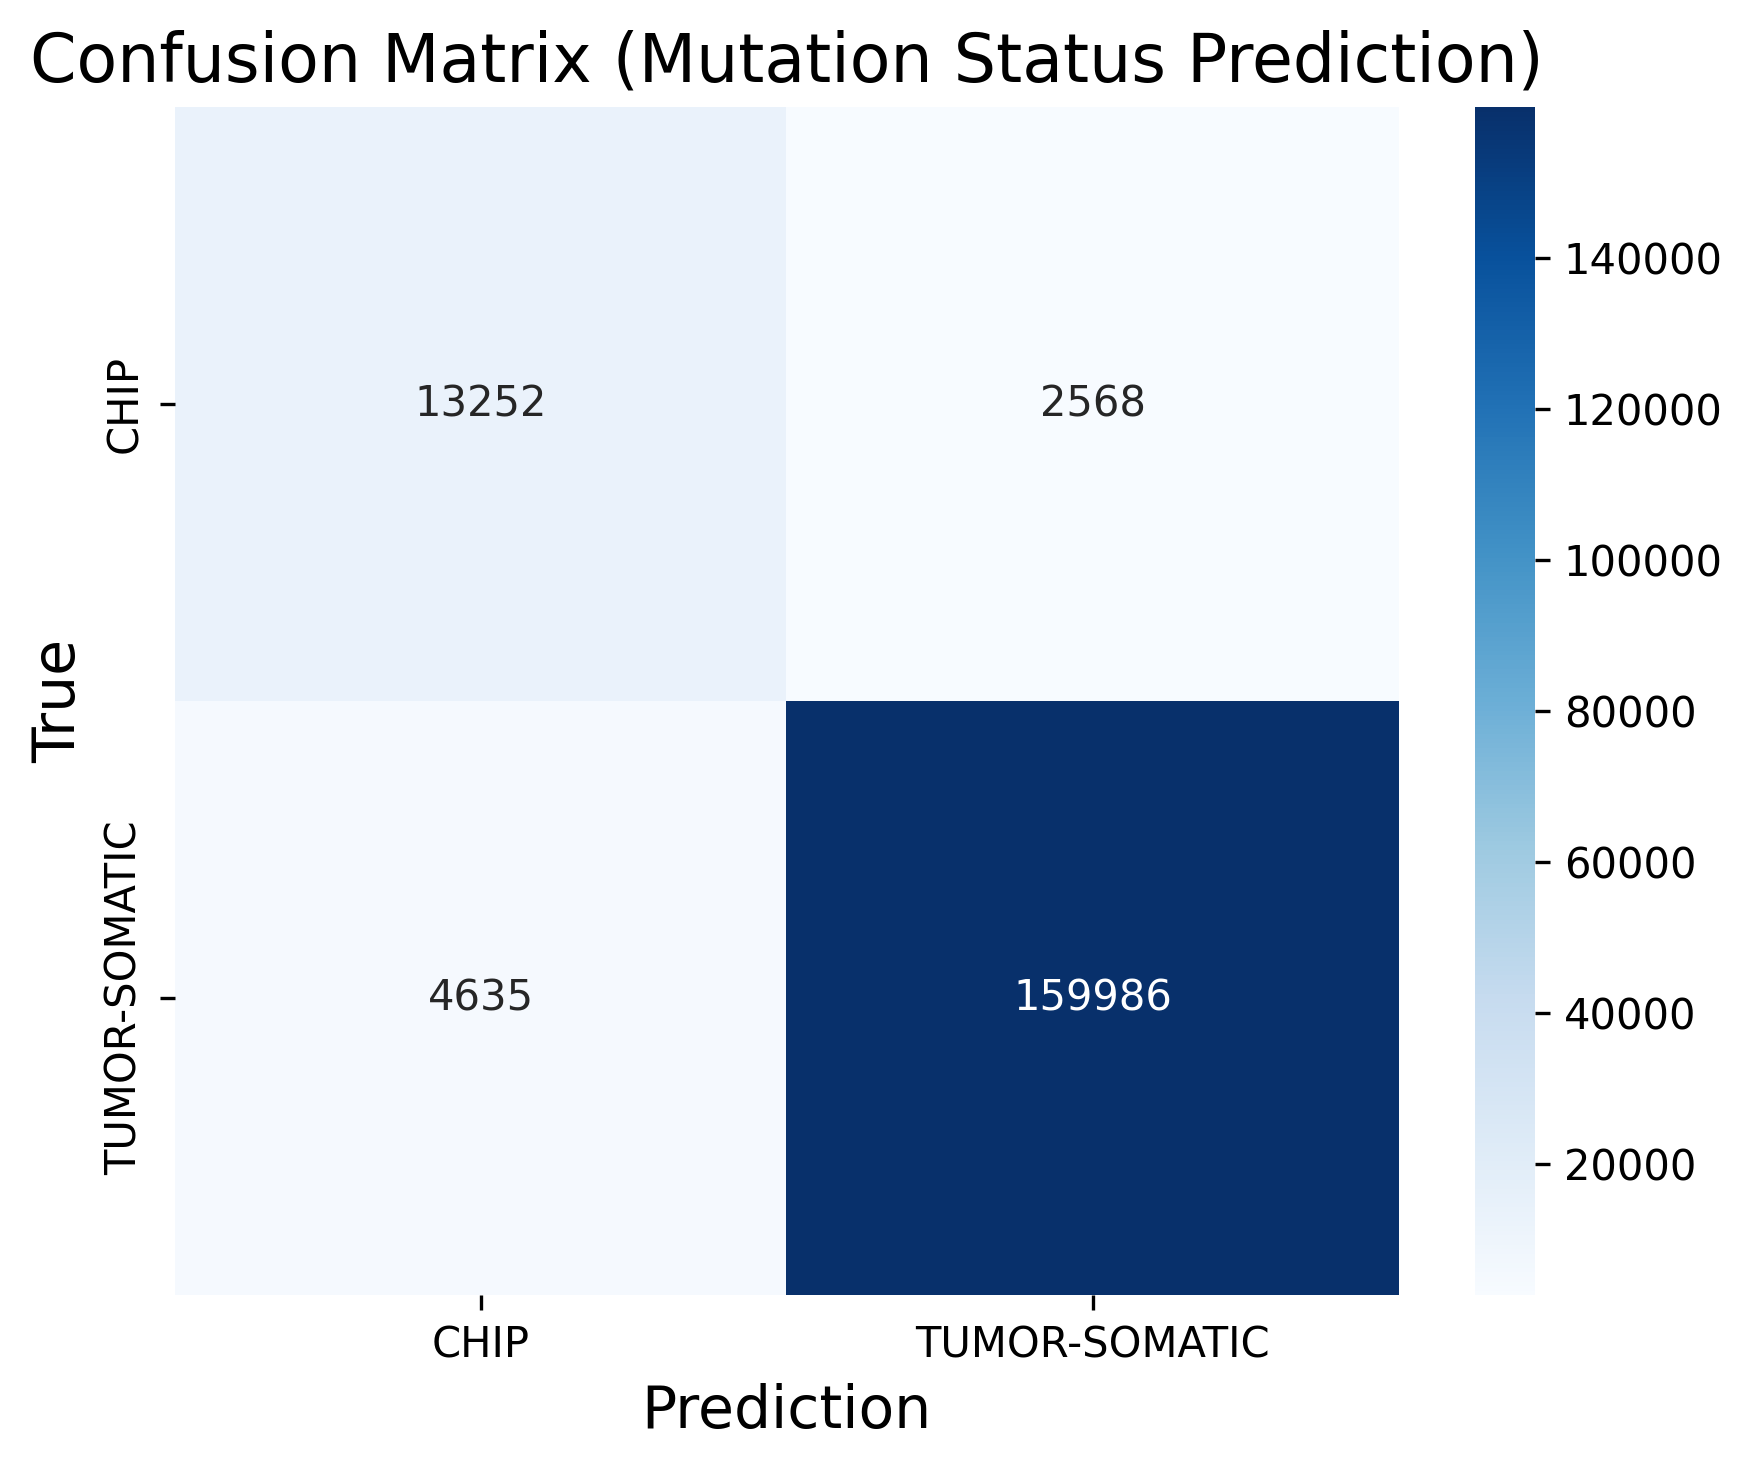


--- Normalized Confusion Matrix ---
                   CHIP  TUMOR-SOMATIC
CHIP           0.837674       0.162326
TUMOR-SOMATIC  0.028156       0.971844
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fff91ef1898>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fff91ef1898> on colorbar
Setting pcolormesh


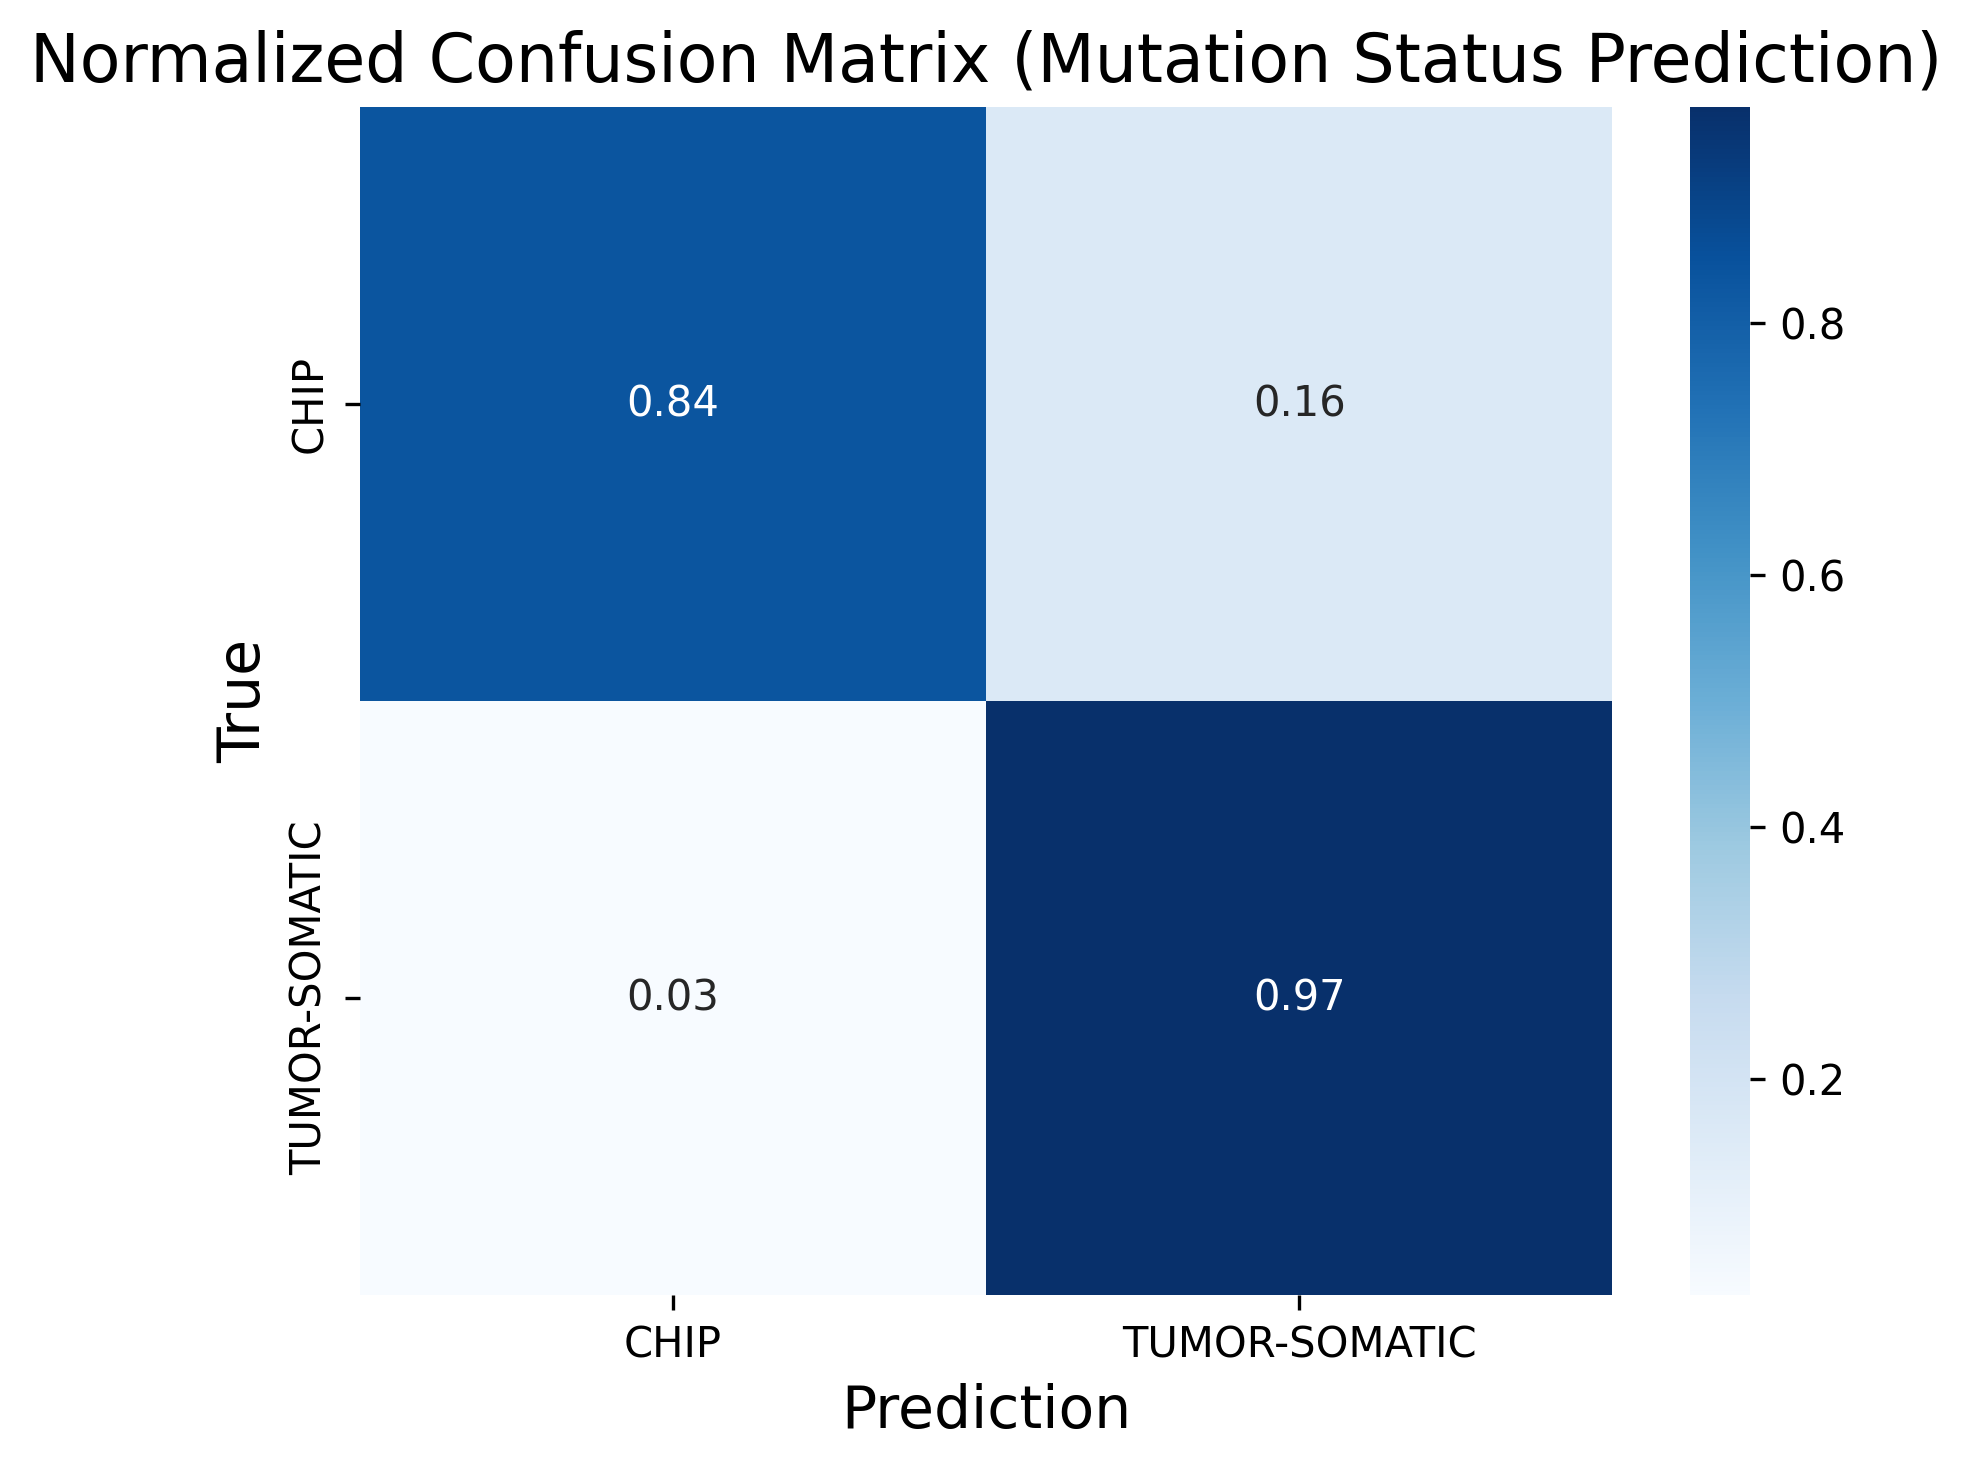

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fff73f0e470>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fff73f0e470> on colorbar
Setting pcolormesh
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 2.05
findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXNonUnicode' (ST

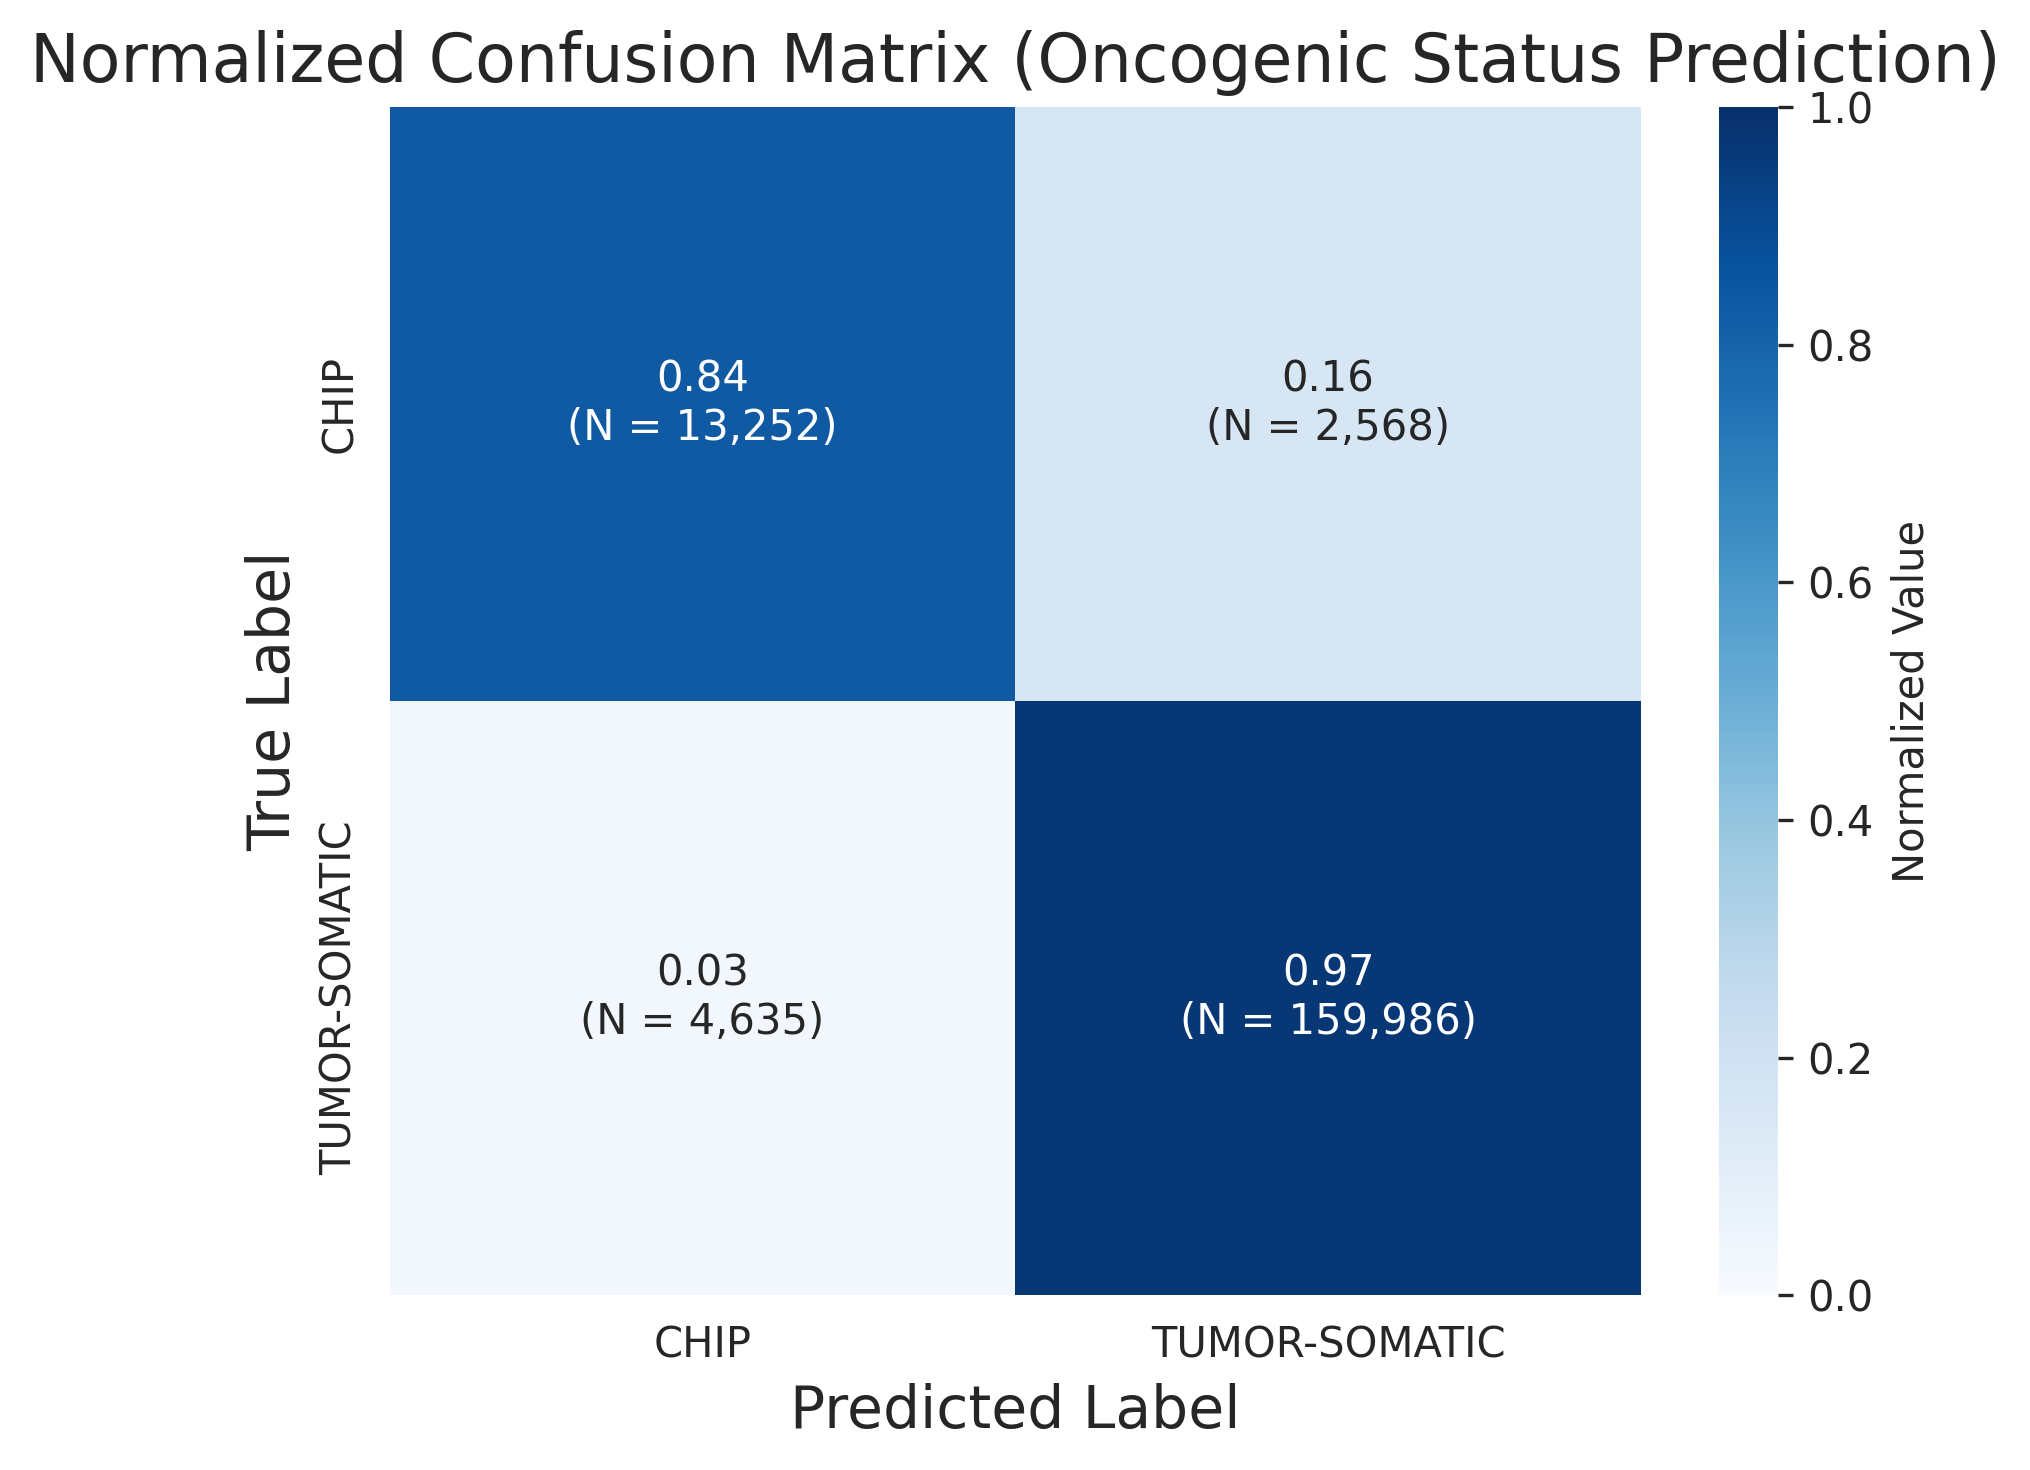

In [8]:

print("\n--- Confusion Matrix ---")
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=categories, normalize=None)
cm_df = pd.DataFrame(cm, 
                     index=categories,
                     columns=categories)
print(cm_df)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5), dpi=300)
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix (Mutation Status Prediction)", fontsize=16)
plt.ylabel("True", fontsize=14)
plt.xlabel("Prediction", fontsize=14)
plt.tight_layout()
plt.show()


# Confusion Matrix (normalized by row)
cm = confusion_matrix(y_true, y_pred, labels=categories, normalize="true")
cm_df = pd.DataFrame(cm, 
                     index=categories,
                     columns=categories)

print("\n--- Normalized Confusion Matrix ---")
print(cm_df)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5), dpi=300)
sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Normalized Confusion Matrix (Mutation Status Prediction)", fontsize=16)
plt.ylabel("True", fontsize=14)
plt.xlabel("Prediction", fontsize=14)
plt.tight_layout()
plt.show()

#==================COMBINED FIGURE================
# Set style
sns.set_style("white")

# Calculate confusion matrices
cm_raw = confusion_matrix(y_true, y_pred, labels=categories)
cm_norm = confusion_matrix(y_true, y_pred, labels=categories, normalize='true')

# Remove last row if needed (as in your original code)
# cm_raw = cm_raw[:-1, :]
# cm_norm = cm_norm[:-1, :]

# Create DataFrame for the heatmap (using normalized values for colors)
cm_df = pd.DataFrame(cm_norm, 
                     index=categories,
                     columns=categories)

# Create annotations with both normalized values and counts
annot = np.empty_like(cm_df, dtype=object)
for i in range(len(categories)):
    for j in range(len(categories)):
        annot[i, j] = f"{cm_norm[i, j]:.2f}\n(N = {cm_raw[i, j]:,})"

# Plot the combined confusion matrix
plt.figure(figsize=(6, 5), dpi=300)
sns.heatmap(cm_df, 
            annot=annot, 
            fmt="", 
            cmap="Blues", 
            cbar=True,
            vmin=0,
            vmax=1,
            cbar_kws={'label': 'Normalized Value'})

plt.title("Normalized Confusion Matrix (Oncogenic Status Prediction)", fontsize=16)
plt.ylabel("True Label", fontsize=14)
plt.xlabel("Predicted Label", fontsize=14)
plt.tight_layout()
plt.show()
